# Thinkful's data loading etc:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set()

In [2]:
# Load the data again. Keep air quality data, drop the index column
# and any missing data columns.
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:,1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default']=='Yes', 1, 0)
df['student'] = np.where(df['student']=='Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Make some new features to capture potential quadratic and cubic
# relationships between solar radiation and day or temperature.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]


In [3]:
# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)
print('R² for the model with few features:')
print(lass.score(X_train, Y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
print('\nR² for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)

R² for the model with few features:
0.450062579301185

Parameter estimates for the model with few features:
[-0.         -0.40657726 -0.          0.00114596]

R² for the model with many features:
0.44363376712897096

Parameter estimates for the model with many features:
[ 0.00000000e+00 -3.89351238e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.77688887e-04
 -7.09158792e-07  3.48711577e+00]


# My part:

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


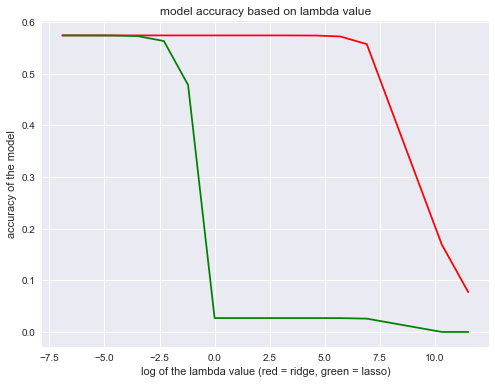

In [9]:
# Your code here
import math
lambdas = [.001, .003, .01, .03, .1, .3, 1, 3, 10, 30, 100, 300, 1000, 30000, 100000]
log_lambdas = [math.log(l) for l in lambdas]
r_scores = []
l_scores = []
for l in lambdas:
    ridge = linear_model.Ridge(alpha=l)
    ridge.fit(X_train2, Y_train)
    r_scores.append(ridge.score(X_train2, Y_train))
    lasso = linear_model.Lasso(alpha=l)
    lasso.fit(X_train2, Y_train)
    l_scores.append(lasso.score(X_train2, Y_train))

plt.figure(figsize=(8,6))
plt.plot(log_lambdas, r_scores, "r", log_lambdas, l_scores, "g")
plt.title("model accuracy based on lambda value")
plt.xlabel("log of the lambda value (red = ridge, green = lasso)")
plt.ylabel("accuracy of the model")
plt.show()


# Conclusions:

Unsurprisingly, the two algorithms differ in the effect of lambda changes.

Significantly, the accuracy of the lasso regression decreases faster as lambda increases. This is because the lambda value (as a range centered around 0) is used as the cutoff for the R score below which variables are dropped.  This is why once the log of lambda is 0 -- which means lambda is 1 -- the coefficients quickly get zeroed out, leaving us with no features at all.

THIS IS REALLY IMPORTANT: it shows that for Lasso regression, the lambda value should be set very carefully, generally below .1.  It also shows that with Lasso regression you can't increase the Occam's Razor aspect of coefficient-reduction without also dropping more coefficients.